# QBUS6830 Tutorial Lab 8: ARCH Models
## Data
In this lab session we will use daily data on BHP returns, from Jan, 2000 to July, 2021. The data can be found in the files `bhp_yf_2000_2021.csv`.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

In [110]:
# Download data automatically if file not present
name_bhp = 'bhp_yf_2000_2021.csv'

# BHP
if not os.path.isfile(name_bhp):
    data_bhp = yf.download("BHP.AX", start='2000-01-01', end='2021-07-20')
    data_bhp.to_csv(name_bhp)

In [111]:
data = pd.read_csv(name_bhp, index_col='Date', parse_dates=True, dayfirst=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,8.317775,8.317775,8.317775,8.317775,3.761002,0
2000-01-04,8.317359,8.620943,8.317359,8.608466,3.892443,9525499
2000-01-05,8.404691,8.462913,8.300724,8.408018,3.801806,8727404
2000-01-06,8.425485,8.566880,8.425485,8.462913,3.826628,7274950
2000-01-07,8.487449,8.941161,8.483706,8.880860,4.015609,15832421
...,...,...,...,...,...,...
2021-07-13,51.459999,51.610001,50.700001,50.700001,47.642834,5725789
2021-07-14,51.000000,51.220001,50.730000,50.959999,47.887154,4033496
2021-07-15,50.970001,51.660000,50.779999,51.529999,48.422783,5757487


#### (a) Transform the prices to percentage log-returns. Plot the price and return series. Comment.

In [112]:
p = data['Adj Close']
r = 100 * np.log(p).diff().dropna()

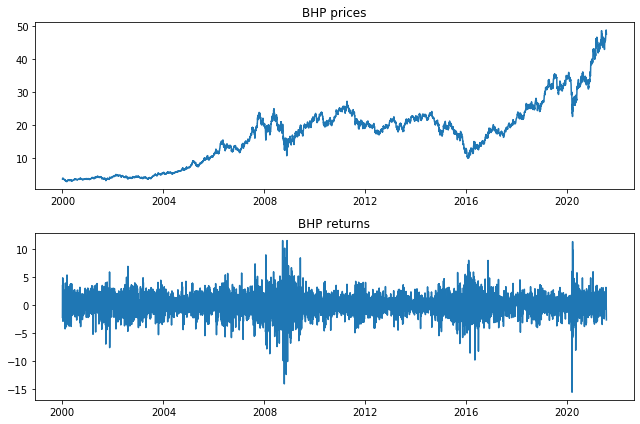

In [113]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(p)
ax[0].set_title('BHP prices')
ax[1].plot(r)
ax[1].set_title('BHP returns')
plt.tight_layout()
plt.show()

### Answer guide
BHP stock prices show a long run, slow up-trend, though with a steeper up-trend since the start of 2020 to now. However, there are also longish periods where the prices were not rising, e.g. 2010-2015; 2007-2009 shows the strong downturns during the GFC, there are also strong price drops at the end of 2015 and when covid hit in early 2020.

Day to day price changes, as reflected in the log-return plot, do not illustrate the long or shorter term trends in the prices; returns seem to always fluctuate around 0 from day to day, with no clear positive autocorrelation in returns. The other clear aspect is that volatility is changing over time and does display clear positive autocorrelation, with long periods of low volatility, e.g. 2010-2015, 2017-2020; and shorter periods of higher volatility, e.g. 2008-2009, 2016, early 2020.  

#### (b) Calculate some relevant summary statistics and then comment on the performance of BHP stock over the sample period. Perform the JB test for Gaussianity on the return series and test the returns for autocorrelation and also for ARCH effects.

In [114]:
descriptive = r.describe()
descriptive['skew'] = r.skew()
descriptive['kurt'] = kurtosis(r, fisher=False)
descriptive.round(4)

count    5450.0000
mean        0.0465
std         1.9097
min       -15.5653
25%        -1.0185
50%         0.0574
75%         1.1373
max        11.4642
skew       -0.2146
kurt        7.3654
Name: Adj Close, dtype: float64

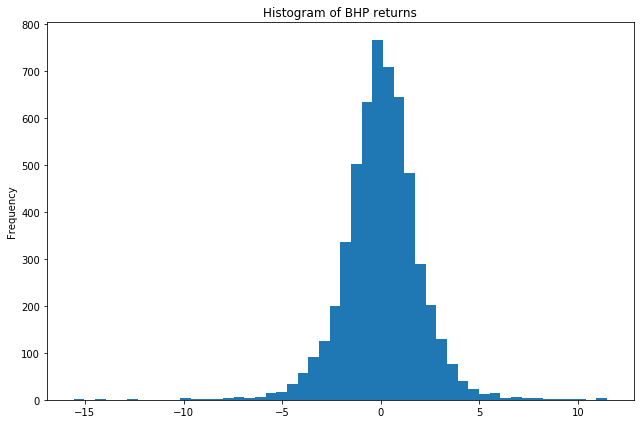

In [115]:
r.plot(kind='hist', bins=50, figsize=(9, 6))
plt.title('Histogram of BHP returns')
plt.tight_layout()
plt.show()

In [116]:
# Null hypothesis - the sample data has the skewness and kurtosis matching a normal distribution
pval = jarque_bera(r)[1]
pval

0.0

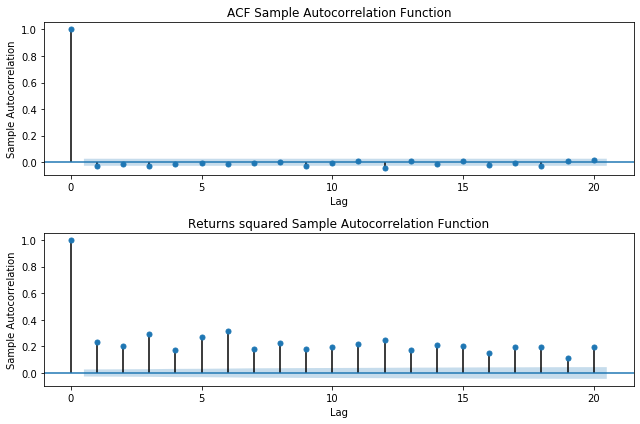

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

# If there exists AR effects
sm.graphics.tsa.plot_acf(r, ax=ax[0], lags=20, alpha=0.05)

ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Sample Autocorrelation')
ax[0].set_title('ACF Sample Autocorrelation Function')

# If there exists ARCH
sm.graphics.tsa.plot_acf(r**2, ax=ax[1], lags=20, alpha=0.05)

ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Returns squared Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [120]:
# Null Hypothesis - The data is independently distributed
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10, 15 ]:
    Qstat, pValue = acorr_ljungbox( r, lags = [p], return_df = False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 11.791583. P-value: 0.037758
maxlag: 10. Q-stat: 16.649205. P-value: 0.082496
maxlag: 15. Q-stat: 30.605860. P-value: 0.009915



In [121]:
# Null Hypothesis - The data is independently distributed
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10, 15 ]:
    Qstat, pValue = acorr_ljungbox( r**2, lags = [p], return_df = False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 1561.065908. P-value: 0.000000
maxlag: 10. Q-stat: 2955.043331. P-value: 0.000000
maxlag: 15. Q-stat: 4181.213701. P-value: 0.000000



### Answer guide 
The BHP daily percentage log-returns have a mean of 0.045%, which is not practically large. They have estimated negative skewness and kurtosis well above 3, both of which are influenced by the larger number of negative than positive positive outliers; shown in the returns plot and in the histogram. The returns are clearly not Gaussian, as Gaussianity is strongly rejected by the JB test (p-val = 0) and the histogram is clearly peaked and fat-tailed.

The returns show mildly significant autocorrelation in the 1st 5 lags (p-val = 0.038), insignificant autocorrelation in the 1st 10 lags (p-val =0.082), but strongly significant in the 1st 15 lags as a whole (p-val = 0.0099). The returns show mild autocorrelation that is not clearly shown in the ACF plot.

The returns show highly significant ARCH effects in the 1st 5, 10 and 15 lags (p-val = 0.00000). The returns show strong ARCH effects, as shown in the ACF of squared returns.

#### (c) Fit an ARCH(1) model to the return data using ML. Report and interpret the parameter estimates and plot the estimated volatility series. Discuss the estimated series and its properties.

In [122]:
arch1 = arch_model(r, mean='Constant', vol='ARCH', dist='normal', p=1)
arch1_fit = arch1.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11014.810580517375
Iteration:      2,   Func. Count:     13,   Neg. LLF: 11014.689588463192
Iteration:      3,   Func. Count:     21,   Neg. LLF: 11014.573548173808
Iteration:      4,   Func. Count:     28,   Neg. LLF: 11014.313938671588
Iteration:      5,   Func. Count:     34,   Neg. LLF: 11014.196420445773
Iteration:      6,   Func. Count:     39,   Neg. LLF: 11014.19424016709
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11014.194239511431
            Iterations: 6
            Function evaluations: 40
            Gradient evaluations: 6


In [123]:
print(arch1_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -11014.2
Distribution:                  Normal   AIC:                           22034.4
Method:            Maximum Likelihood   BIC:                           22054.2
                                        No. Observations:                 5450
Date:                Fri, Oct 08 2021   Df Residuals:                     5449
Time:                        11:12:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0617  2.382e-02      2.592  9.552e-03 [1.505e-0

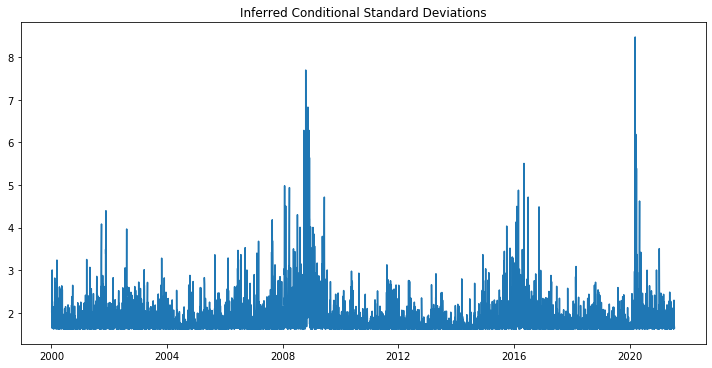

In [62]:
s1 = arch1_fit.conditional_volatility
plt.figure(figsize=(10, 5))
plt.plot(s1)
plt.tight_layout()
plt.title('Inferred Conditional Standard Deviations')
plt.show()

### Answer guide
The estimated model is $\sigma_t^2 = 2.60 + 0.28 a_{t-1}^2$, where $a_t = r_t - 0.062$ and $a_t | r_1, ..., r_{t-1} \sim N(0, \sigma_t^2$. The estimated conditional and unconditional mean return is 0.062%. Conditional variance at time $t$ is 2.60 plus 0.28 times yesterday's squared return shock; if the return shock squared increased by 1 unit, the conditional variance would increase by 0.28, on average.

The estimated conditional standard deviation (volatility) series, $\sigma_t$, is a very non-smooth series. This series tends to be lower e.g. 2004-2007, 2010-2015, 2017-2019; but higher in others, e.g. 2007-2009, 2016, early 2020.  

#### (d) Compare the unconditional variance estimated from the ARCH model with the sample variance? Are these close?

In [124]:
a0 = arch1_fit.params['omega']
a11 = arch1_fit.params['alpha[1]']
unc_var = a0 / (1-a11)
unc_var

3.6302475926374225

In [16]:
smp_var = r.var()
smp_var

3.647070792109454

### Answer guide
Yes, these are very close indeed. 

#### (e) Compare the unconditional kurtosis estimated from the ARCH model with the sample kurtosis? Are these close?

In [17]:
unc_kurt = 3 * (1 - a11 ** 2) / (1 - 3 * a11 ** 2)
unc_kurt

3.634514244419537

In [18]:
smp_kurt = kurtosis(r, fisher=False)
smp_kurt

7.365429309452179

### Answer guide
No, they are not close at all. The ARCH-model-based estimate is much, much lower and indicates a distribution much closer, in the tails, to a Gaussian than the sample kurtosis suggests.

FYI the model-based estimate is usually considered more accurate, as it is more robust to outliers. 

#### (f) Find the LS (using the squared errors) estimates for the parameters. Are these close to the ML estimates?

For LS estimation, simply fit an OLS regression of the squared errors ($a_t^2$) on their
lagged values ($a_{t-1}^2$). 

In [125]:
a2 = (r[1:] - r.mean()) ** 2
a2_lag = (r[:-1] - r.mean()) ** 2

x = sm.add_constant(a2_lag.values)

ols = sm.OLS(a2, x).fit(cov_type='HC0')    # NB I uses heteroscedastic-consistent covariance here.
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     46.83
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           8.58e-12
Time:                        11:23:08   Log-Likelihood:                -19674.
No. Observations:                5449   AIC:                         3.935e+04
Df Residuals:                    5447   BIC:                         3.937e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8008      0.120     23.271      0.0

### Answer guide
The estimated model is $\sigma_t^2 = 2.80 + 0.23 a_{t-1}^2$, where $a_t = r_t - 0.045$ and $a_t | r_1, ..., r_{t-1} \sim N(0, \sigma_t^2$. The OLS method estimates that: if the return shock squared increased by 1 unit at time $t-1$, the conditional variance at time $t$ would increase by 0.23, on average.

The OLS and ML estimates are reasonably close to each other in this data.

#### (g) Repeat parts (d) and (e) for the LS estimates.

In [128]:
a0_ols = ols.params['const']
a1_ols = ols.params['x1']
unc_var_ols = a0_ols / (1-a1_ols)
unc_var_ols

3.6447385737937616

In [129]:
unc_kurt_ols = 3 * (1 - a1_ols ** 2) / (1 - 3 * a1_ols ** 2)
unc_kurt_ols

3.3833046461827827

### Answer guide
The OLS model-based unconditional variance estimate is almost exactly the same as the sample variance. However the OLS-model based kurtosis (3.38) is a bit lower than the ML based kurtosis estimate (3.63), indicating (incorrectly) near normality of the tails of the return distribution.  

#### (h) Are the unconditional variance and kurtosis estimates from the LS and ML estimates close to each other? Are they close to the sample variance and kurtosis? If they are not, why do you think this might be?

The OLS, ML and sample estimates of the unconditional variance are all nearly identical. 

The OLS, ML and sample estimates of the unconditional kurtosis are all quite different. Both model estimates are much, much lower than the sample estimate of 7.4. The OLS based estimate is closer to 3 (Gaussian) than the ML estimate is. 

In general, the model-based estimates are preferred since they are more outlier robust. Further the ML estimates are more robust than the OLS estimates and make fewer assumptions about moments of returns (e.g. OLS assumes 8th moment of returns is finite).  

#### (i) Use the AIC and SIC functions to identify a suitable ARCH model order for the BHP return data.

In [136]:
aic = np.zeros(20)
bic = np.zeros(20)

for i in range(1, 21):
    arch = arch_model(r, mean='Constant', vol='ARCH', dist='normal', p=i)
    fit = arch.fit( disp= 'off' )
    aic[i - 1] = fit.aic
    bic[i - 1] = fit.bic

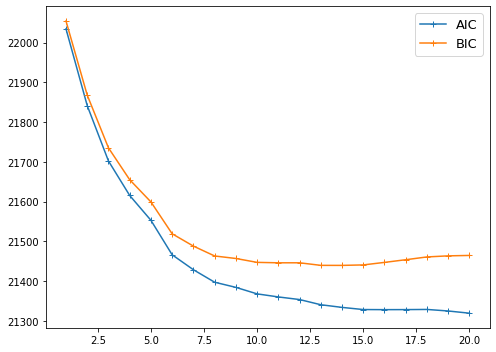

In [137]:
# AIC, SIC plot
p = np.arange(1, 21)
plt.figure(figsize=(7, 5))
plt.plot(p, aic, '-+', label='AIC')
plt.plot(p, bic, '-+', label='BIC')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

In [138]:
tbl_ic = pd.DataFrame({'AIC': aic.round(0), 'BIC': bic.round(0)}, index=p)
tbl_ic.index.name = 'p'
tbl_ic.T

p,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AIC,22034.0,21841.0,21702.0,21615.0,21553.0,21466.0,21429.0,21397.0,21384.0,21368.0,21360.0,21354.0,21341.0,21334.0,21328.0,21328.0,21328.0,21329.0,21325.0,21319.0
BIC,22054.0,21868.0,21735.0,21655.0,21599.0,21519.0,21488.0,21463.0,21457.0,21447.0,21446.0,21446.0,21440.0,21439.0,21441.0,21447.0,21454.0,21461.0,21463.0,21465.0


### Answer guide
The AIC chooses $p=20$ and the SIC chooses $p=14$. For parsimony, I choose an ARCH(14) model.

### (j)  Fit the constant mean Gaussian ARCH model with lag order chosen in part (e). What is the fitted model? Are all chosen ARCH lags significant?

In [139]:
archp_ = arch_model(r, mean='Constant', vol='ARCH', dist='normal', p=14)
archp_fit = archp_.fit( disp='off' )
print(archp_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -10650.9
Distribution:                  Normal   AIC:                           21333.8
Method:            Maximum Likelihood   BIC:                           21439.5
                                        No. Observations:                 5450
Date:                Fri, Oct 08 2021   Df Residuals:                     5449
Time:                        11:30:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0756  2.088e-02      3.621  2.931e-04 [3.469e-0

### Answer guide
The estimated model is $\sigma_t^2 = 0.80 + 0.094 a_{t-1}^2+ 0.056 a_{t-2}^2+ 0.081 a_{t-3}^2+ 0.050 a_{t-4}^2+ 0.067 a_{t-5}^2+ 0.091 a_{t-6}^2+ 0.058 a_{t-7}^2+ 0.044 a_{t-8}^2+ 0.034 a_{t-9}^2+ 0.042 a_{t-10}^2+ 0.033 a_{t-11}^2+ 0.039 a_{t-12}^2+ 0.051 a_{t-13}^2+ 0.041 a_{t-14}^2$, where $a_t = r_t - 0.076$ and $a_t | r_1, ..., r_{t-1} \sim N(0, \sigma_t^2)$.

For a 5% significance level, all ARCH lag estimates are significantly different to 0, except lag 9 (p-val = 0.056).

### (k) Compare the estimated volatility for the ARCH model in (j) with that of the ARCH(1). How and why are they different?

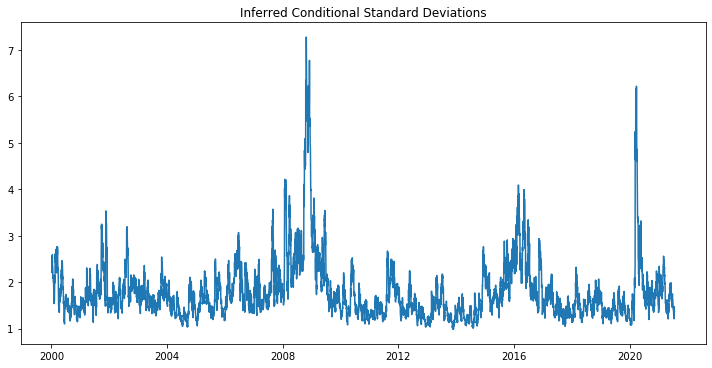

In [141]:
sp = archp_fit.conditional_volatility
plt.figure(figsize=(10, 5))
plt.plot(sp)
plt.tight_layout()
plt.title('Inferred Conditional Standard Deviations')
plt.show()

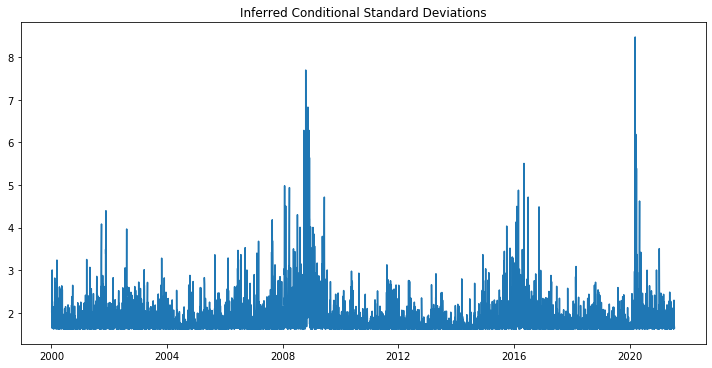

In [142]:
s1 = arch1_fit.conditional_volatility
plt.figure(figsize=(10, 5))
plt.plot(s1)
plt.tight_layout()
plt.title('Inferred Conditional Standard Deviations')
plt.show()

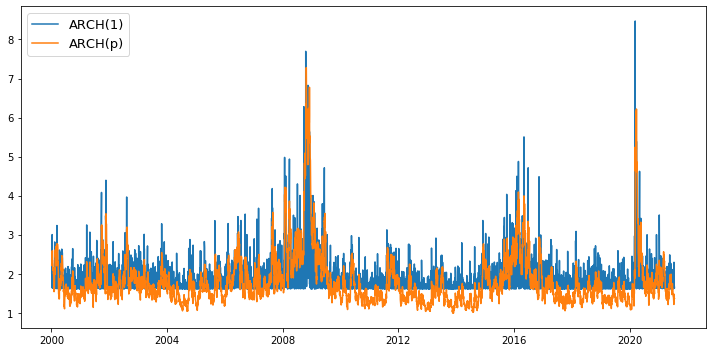

In [59]:
plt.figure(figsize=(10, 5))

plt.plot(s1, label='ARCH(1)')
plt.plot(sp, label='ARCH(p)')

plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Answer guide
Clearly the ARCH(14) estimated volatility series is much smoother than that for the ARCH(1). It also, doesn't get near to or hit the lower limit (which is $\sqrt{\alpha_0}$) nearly as often as the ARCH(1) series does. Both of these are because the estimates of $\sigma_t$ in the ARCH(14) is informed by 14 previous days of squared shocks instead of only 1 day for the ARCH(1). We thus get a smoother series that can have a lower bound closer to 0 but never hit it.  

### (l) Assess the fits of the two ARCH models, using ACF plots, Ljung-Box and ARCH tests and a histogram/qqplot together with the Jarque-Bera test. 

Before I begin, standardized should be spelt with an 's' not a 'z'. But I write with the z to follow American English, for reasons.

So here we are not looking at the innovations, but the standardized innovations and this is very important.

Recall, the innovations are expected to be distributed like $\varepsilon_t\sim\mathcal{N}(0,\sigma_t^2)$. In other words, we expect the innovations to have time varying volatility. But the standardized innovations are defined as
$$\frac{\varepsilon_t}{\sigma_t}\sim\mathcal{N}(0, 1),$$
where $\sigma_t$ is the value you get from the (G)ARCH model.

The critical difference is that, in the standardized innovations we don't get time varying behaviour. Instead we should expect constant variance, with the key being that we expect. As such, we make plots of standardized innovations  to see if our volatility model worked correctly. In particular, if in the **standardized innovations**
- There exists time varying volatility, then the volatiltiy model is not good. Otherwise, if
- There does not exist time varying volaitliy, then the volatility model is good

In [144]:
innovations = arch1_fit.resid
std = arch1_fit.conditional_volatility

standardized_innovations = arch1_fit.std_resid

In [145]:
(innovations / std) == standardized_innovations

Date
2000-01-04    True
2000-01-05    True
2000-01-06    True
2000-01-07    True
2000-01-10    True
              ... 
2021-07-13    True
2021-07-14    True
2021-07-15    True
2021-07-16    True
2021-07-19    True
Length: 5450, dtype: bool

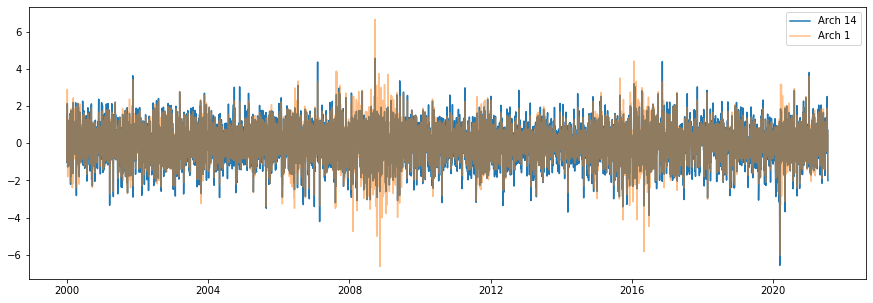

In [152]:
plt.figure(figsize=(15, 5))
plt.plot(archp_fit.std_resid, label='Arch 14')
plt.plot(arch1_fit.std_resid, label='Arch 1', alpha=0.5)
plt.legend();

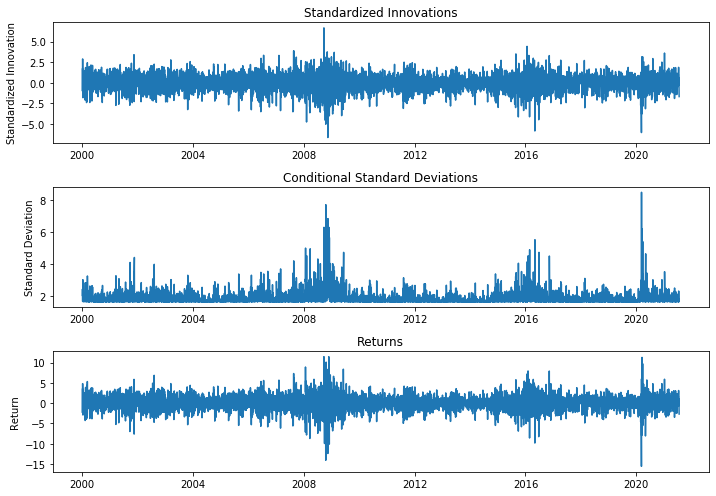

In [63]:
#ARCH(1)
a = arch1_fit.resid
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

e1 = arch1_fit.std_resid
ax[0].plot(e1)
ax[0].set_title('Standardized Innovations')
ax[0].set_ylabel('Standardized Innovation')

s1 = arch1_fit.conditional_volatility
ax[1].plot(s1)
ax[1].set_title('Conditional Standard Deviations')
ax[1].set_ylabel('Standard Deviation')

ax[2].plot(r)
ax[2].set_title('Returns')
ax[2].set_ylabel('Return')
plt.tight_layout()
plt.show()

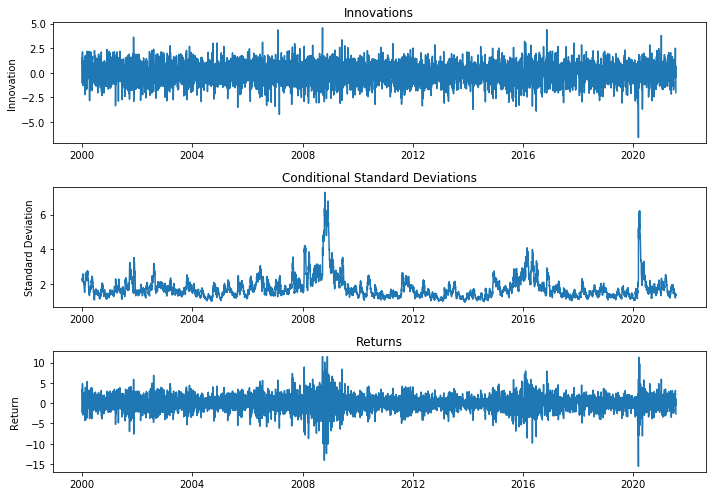

In [74]:
#ARCH(p)
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

a = archp_fit.resid

ep = archp_fit.std_resid
ax[0].plot(ep)
ax[0].set_title('Innovations')
ax[0].set_ylabel('Innovation')

sp = archp_fit.conditional_volatility
ax[1].plot(sp)
ax[1].set_title('Conditional Standard Deviations')
ax[1].set_ylabel('Standard Deviation')

ax[2].plot(r)
ax[2].set_title('Returns')
ax[2].set_ylabel('Return')

plt.tight_layout()
plt.show()

### Answer guide 
The ARCH(1) model innovations seem to display changing volatility over time and do not look like white noise. They also display some outliers beyond -5 or 5, which is very unlikely under a Gaussian distribiution. 

The ARCH(14) model innovations do not display clearly changing volatility over time and look closer like white noise. They also display some outliers beyond -5 or 4, which again is very unlikely under a Gaussian distribiution. 

In [153]:
# To see if there is remaining AR effects
print( "Ljung-Box Q-statistic ARCH(1):" )
for p in [ 6, 11 ]:
    Qstat, pValue = acorr_ljungbox(arch1_fit.std_resid, lags=[p], model_df=1, return_df = False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()

Ljung-Box Q-statistic ARCH(1):
maxlag: 6. Q-stat: 4.657929. P-value: 0.459035
maxlag: 11. Q-stat: 10.765266. P-value: 0.376096



In [154]:
# To see if there is remaining AR effects
print( "Ljung-Box Q-statistic ARCH(p):" )
for p in [ 19, 24 ]:
    Qstat, pValue = acorr_ljungbox(archp_fit.std_resid, lags=[p], model_df=14, return_df = False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()

Ljung-Box Q-statistic ARCH(p):
maxlag: 19. Q-stat: 18.383265. P-value: 0.002503
maxlag: 24. Q-stat: 18.645100. P-value: 0.045009



### Answer guide
The Ljung-Box test is applied to assess the level of autocorrelation in the innovations from the ARCH(1) model at lags 1-6 and 1-11 combined. In both cases we find no significant correlations in the first 6 or 11 lags with p-values > 0.05. Note that since an ARCH(1) was applied, the degrees of freedom are 6-1 = 5 and 11-1 = 10 respectively. 

The Ljung-Box test is applied to assess the level of autocorrelation in the innovations from the ARCH(14) model at lags 1-19 and 1-24 combined. In both cases we find significant correlations in the first 19 or 24 lags with p-values < 0.05. Note that since an ARCH(14) was applied, the degrees of freedom are 19-14 = 5 and 24-1 = 23 respectively. 

Thus, the constant mean equation cannot be rejected in the ARCH(1), but can be rejected in the ARCH(14) model. 

In [37]:
# To see if there is remaining ARCH effects

# Null Hypothesis - Data is indepdnently Distributed
print( "Ljung-Box Q-statistic ARCH(1):" )
for p in [ 6, 11 ]:
    Qstat, pValue = acorr_ljungbox( e1**2, lags=[p], model_df=1, return_df = False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()

Ljung-Box Q-statistic ARCH(1):
maxlag: 6. Q-stat: 450.445837. P-value: 0.000000
maxlag: 11. Q-stat: 762.065560. P-value: 0.000000



In [156]:
# To see if there is remaining ARCH effects

print( "Ljung-Box Q-statistic ARCH(1):" )
for p in [ 19, 24 ]:
    Qstat, pValue = acorr_ljungbox( ep**2, lags=[p], model_df=14, return_df = False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
print()

Ljung-Box Q-statistic ARCH(1):
maxlag: 19. Q-stat: 13.798823. P-value: 0.016939
maxlag: 24. Q-stat: 16.894159. P-value: 0.076739



### Answer guide
The Ljung-Box test is applied to assess the level of ARCH effects remaining in the innovations from the ARCH(1) model at lags 1-6 and 1-11 combined. In both cases we find highly significant correlations in the first 6 or 11 lags of squared innovations, with p-values $\approx 0$. Note that since an ARCH(1) was applied, the degrees of freedom are 6-1 = 5 and 11-1 = 10 respectively. 

The Ljung-Box test is applied to assess the level of ARCH effects remaining in the innovations from the ARCH(14) model at lags 1-19 and 1-24 combined. In both cases we find significant correlations in the first 19 lags with p-values =0.016, but not significant in the first 24 lags, p-value = 0.077. Note that since an ARCH(14) was applied, the degrees of freedom are 19-14 = 5 and 24-1 = 23 respectively. 

Thus, the ARCH(1) variance equation can be strongly rejected for these returns. 

The ARCH(14) variance equation can be rejected at 19 lags, but cannot be rejected at 24 lags.  

### Q-Q Plots
Again, the innovations are expected to be distributed like $\varepsilon_t\sim\mathcal{N}(0,\sigma_t^2)$, with the standardized innovations are defined as
$$\frac{\varepsilon_t}{\sigma_t}\sim\mathcal{N}(0, 1).$$

Now, before we were only looking for time varying behaviour, and we did this by looking at the auto-correlation and plots of the standardized innovations. But we still need to check one thing, that the standardized innovations are normally distributed. No other way to do this than to look at Q-Q plots.

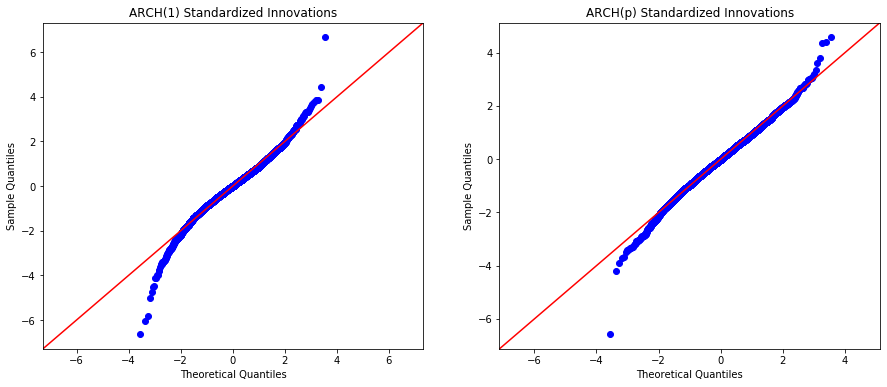

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sm.qqplot(arch1_fit.std_resid, ax=ax[0], line='45');
sm.qqplot(archp_fit.std_resid, ax=ax[1], line='45');

ax[0].set_title('ARCH(1) Standardized Innovations')
ax[1].set_title('ARCH(p) Standardized Innovations');

In [157]:
# Null Hypothesis - Data was drawn from a normal distribution
_, pvalue, _, _ = jarque_bera(arch1_fit.std_resid)
print("JB P-Value for ARCH(1):", format(pvalue, '.4f'))

_, pvalue, _, _ = jarque_bera(archp_fit.std_resid)
print("JB P-Value for ARCH(p):", format(pvalue, '.4f'))

JB P-Value for ARCH(1): 0.0000
JB P-Value for ARCH(p): 0.0000


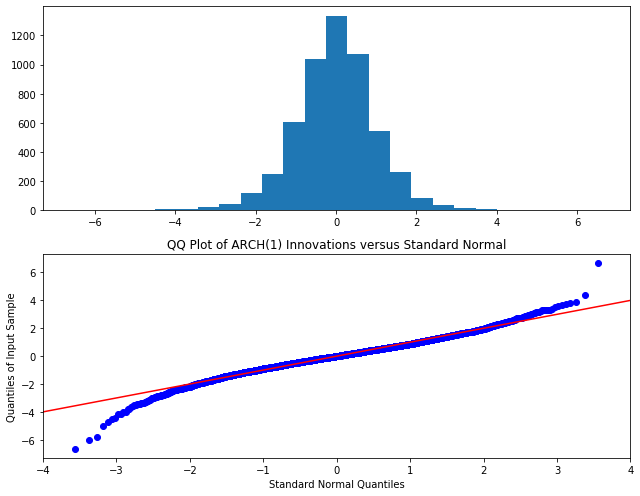

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].hist(e1, bins=25)
sm.qqplot(e1, ax=ax[1], line='45')
ax[1].set_xlim(-4, 4)
ax[1].set_xlabel('Standard Normal Quantiles')
ax[1].set_ylabel('Quantiles of Input Sample')
ax[1].set_title('QQ Plot of ARCH(1) Innovations versus Standard Normal')
plt.tight_layout()
plt.show()

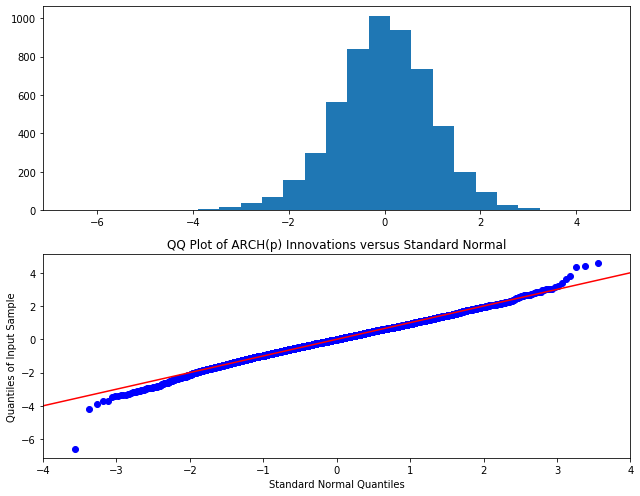

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].hist(ep, bins=25)
sm.qqplot(ep, ax=ax[1], line='45')
ax[1].set_xlim(-4, 4)
ax[1].set_xlabel('Standard Normal Quantiles')
ax[1].set_ylabel('Quantiles of Input Sample')
ax[1].set_title('QQ Plot of ARCH(p) Innovations versus Standard Normal')
plt.tight_layout()
plt.show()

In [41]:
## Jarque-Bera tests ARCH(1)
from statsmodels.stats.stattools import jarque_bera
print( 'Skewness: {0:f}'.format( stats.skew( e1 ) ) )
print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e1 ) + 3 ) )
JB_test_stat, JB_pvalue, _, _ = jarque_bera( e1 )
print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
print()

Skewness: -0.224496
Kurtosis: 5.252772
JB test statistic: 1198.222661. P-value 0.000000



In [42]:
## Jarque-Bera tests ARCH(p)
from statsmodels.stats.stattools import jarque_bera
print( 'Skewness: {0:f}'.format( stats.skew( ep ) ) )
print( 'Kurtosis: {0:f}'.format( stats.kurtosis( ep ) + 3 ) )
JB_test_stat, JB_pvalue, _, _ = jarque_bera( ep )
print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
print()

Skewness: -0.158703
Kurtosis: 3.877215
JB test statistic: 197.619822. P-value 0.000000



### Answer guide
The histogram and QQplot of the innovations from the ARCH(1) illustrate that these have fat-tails, with sample kurtosis of 5.25; the negative skewness is also apparent, as are the negative apparent outliers beyond -4. Consequently, the JB test finds significant non-Gaussianity in these innovations, with p-value $\approx 0$. 

The histogram and QQplot of the innovations from the ARCH(14) illustrate that these still have fat-tails, with sample kurtosis of 3.88; the negative skewness is also apparent, as are a few negative apparent outliers beyond -4. Consequently, the JB test finds significant non-Gaussianity in these innovations, with p-value $\approx 0$. 

### (m) Has the fit improved from the ARCH(1) to the higher lag ARCH model?

### Answer guide
The ARCH(14) model has improved somewhat over the ARCH(1) model. The variance equation is only weakly rejected for the ARCH(14), while strongly rejected for the ARCH(1); the innovations for the ARCH(14) are closer to Gaussian white noise, though are still rejected by the JB test.  

#### (n) Compare the unconditional variance estimated from the ARCH(p) model in (i) and ARCH(1) model and with the sample variance? Are these close? Also compare the estimate of volatility persistence between the 2 models

In [158]:
a0_p = archp_fit.params[1]
a1_p = archp_fit.params[2:]

archp_unc = a0_p/(1 - sum(a1_p))
unc_var, archp_unc 

(3.6302475926374225, 3.6255275656358186)

In [159]:
a11, sum(a1_p)

(0.2833412367276068, 0.7790007950094137)

#### Answer guide
Both models give very similar estimates of the unconditional variance. However, the ARCH(14) gives a much higher estimate of the volatility persistence (being the sum of the ARCH lag estimates). This reflects the much slower mean reversion in the ARCH(14) volatility series, whereas the ARCH(1) volatility series jumps up and down a lot from day to day, hence it has quicker mean reversion. The smoothnss of the ARCH(14) volatility contributes to this higher persistence (slower reversion). Take another look at the two estimated volatility series above to see this.

### (o) Fit a GARCH(1,1) model to the BHP returns. Compare the estimates of volatility from the GARCH and ARCH models. 

In [161]:
garch1 = arch_model(r, vol='GARCH', p=1, q=1, dist='normal')
garch1_fit = garch1.fit( disp= 'off' )
print(garch1_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10628.6
Distribution:                  Normal   AIC:                           21265.2
Method:            Maximum Likelihood   BIC:                           21291.6
                                        No. Observations:                 5450
Date:                Fri, Oct 08 2021   Df Residuals:                     5449
Time:                        11:56:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0697  2.095e-02      3.328  8.763e-04 [2.865e-0

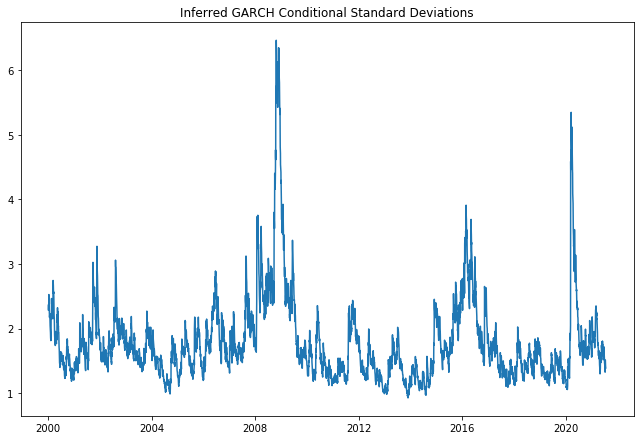

In [162]:
sg1 = garch1_fit.conditional_volatility
plt.figure(figsize=(9, 6))
plt.plot(sg1)
plt.tight_layout()
plt.title('Inferred GARCH Conditional Standard Deviations')
plt.show()

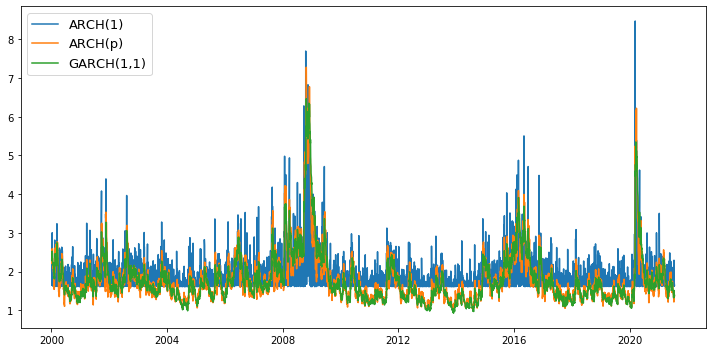

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(s1, label='ARCH(1)')
plt.plot(sp, label='ARCH(p)')
plt.plot(sg1, label='GARCH(1,1)')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

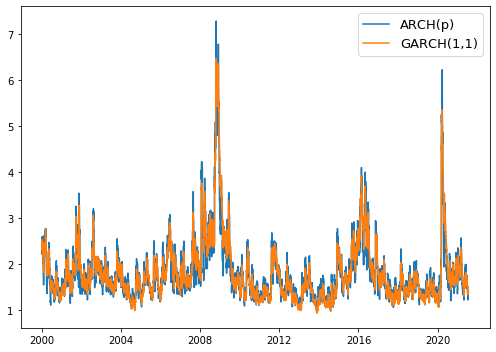

In [164]:
plt.figure(figsize=(7, 5))
plt.plot(sp, label='ARCH(p)')
plt.plot(sg1, label='GARCH(1,1)')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

#### Answer guide
The GARCH(1,1) gives a very similar estimated volatility series to the ARCH(14). The nice feature of that is that it used only 3 variance equation parameters, instead of 15 for the ARCH(14) model. The GARCH gives a much more parsimonious representation of the volatility series, but seems very similar to the ACRH(14); if anything, I would say the GARCH gives a slightly smoother volatility series than the ARCH(14), since the orange line often has the blue either just above or just below it.

### (p) Compare the model-based estimates of unconditional variance, kurtosis and volatility persistence between the ARCH(p) model in (i) and the GARCH model.

In [165]:
a0 = garch1_fit.params['omega']    #obtain constant term from conditional vol equation
a1 = garch1_fit.params['alpha[1]'] #obtain coefficient of a(t-1)^2 in cond. vol equation
b1 = garch1_fit.params['beta[1]'] #obtain coefficient of volatility in cond. vol equation

fit_var = a0/(1-a1-b1)

print( 'GARCH unc variance: %g' %  fit_var)
print( 'ARCH(p) unc variance: %g' %  archp_unc)
print( 'ARCH(1) unc variance: %g' %  unc_var)

GARCH unc variance: 3.57486
ARCH(p) unc variance: 3.62553
ARCH(1) unc variance: 3.63025


In [166]:
# volatility persistence
a11, sum(a1_p), a1+b1

(0.2833412367276068, 0.7790007950094137, 0.9887281446098928)

In [167]:
# GARCH kurtosis
fit_kurt = 6*a1**2/(1 - 2*a1**2 - (a1+b1)**2) + 3

print( 'GARCH kurtosis estimate: %g' % fit_kurt )
print( 'ARCH(1) kurtosis estimate: %g' % unc_kurt )

GARCH kurtosis estimate: 4.99434
ARCH(1) kurtosis estimate: 3.63451


#### Answer guide
The 3 models give very similar estimates of the unconditional variance of BHP returns. However the volatility persistence differs greatly between the 3 models, being: 0.28 for ARCH(1), 0.78 for ARCH(14) and 0.99 for the GARCH model. The highly smooth GARCH volatility series is consistent with a very high persistence estimate. 

Finally, the model based kurtosis estimate is much higher for GARCH, at 4.99, than for ARCH(1), which is 3.64.

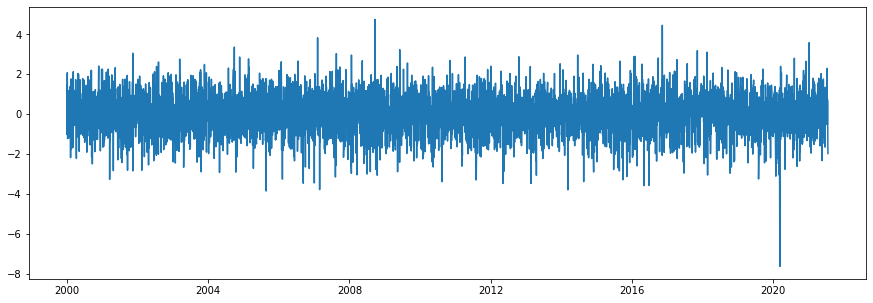

In [169]:
plt.figure(figsize=(15, 5))
plt.plot(garch1_fit.std_resid);

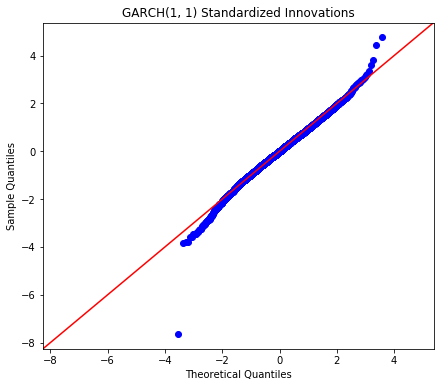

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sm.qqplot(garch1_fit.std_resid, ax=ax, line='45')

ax.set_title('GARCH(1, 1) Standardized Innovations');